In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=8b606a5e62f9c39909d7974e5f6791e604c227403f12e73da25b43b80cb48d0b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
import torchviz
from torch.autograd import Variable
from IPython.display import SVG


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/DSA110_RFI

/content/drive/My Drive/Colab Notebooks/DSA110_RFI


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/DSA110_RFI/dataset.zip' -d /content/dataset

Streaming output truncated to the last 5000 lines.
   creating: /content/dataset/valid_src/observation_211/images/
  inflating: /content/dataset/valid_src/observation_211/metadata.csv  
   creating: /content/dataset/valid_src/observation_35/images/
  inflating: /content/dataset/valid_src/observation_35/metadata.csv  
   creating: /content/dataset/valid_src/observation_229/images/
  inflating: /content/dataset/valid_src/observation_229/metadata.csv  
   creating: /content/dataset/valid_src/observation_216/images/
  inflating: /content/dataset/valid_src/observation_216/metadata.csv  
   creating: /content/dataset/valid_src/observation_242/images/
  inflating: /content/dataset/valid_src/observation_242/metadata.csv  
   creating: /content/dataset/valid_src/observation_289/images/
  inflating: /content/dataset/valid_src/observation_289/metadata.csv  
   creating: /content/dataset/valid_src/observation_61/images/
  inflating: /content/dataset/valid_src/observation_61/metadata.csv  
   creat

In [ ]:
cd /content

/content


In [ ]:
ls

dataset/  drive/  sample_data/


In [ ]:

class ImageCubeDataset(Dataset):
    def __init__(self, root_dir, label, transform=None):
        self.obs_dirs = [os.path.join(root_dir, obs)
                         for obs in sorted(os.listdir(root_dir))
                         if os.path.isdir(os.path.join(root_dir, obs))]
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.obs_dirs)

    def __getitem__(self, idx):
        obs_dir = self.obs_dirs[idx]
        image_cube = self.load_image_cube(obs_dir)
        if self.transform:
            image_cube = self.transform(image_cube)
        return image_cube, self.label

    def load_image_cube(self, observation_dir):
        subband_images = []
        image_dir = os.path.join(observation_dir, 'images')
        filenames = sorted(os.listdir(image_dir))

        for filename in filenames:
            if filename.endswith(".png") and "subband_avg" in filename:
                img_path = os.path.join(image_dir, filename)
                img = Image.open(img_path).convert('L')  # image to grayscale
                subband_images.append(img)



        tensor_stack = torch.stack([transforms.ToTensor()(img)[0] for img in subband_images], dim=0)




        return tensor_stack


# TODO normalization?
transform = transforms.Compose([
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(50, scale=(0.8, 1.0)),
    transforms.Resize((50, 50)),
])
# datasets
train_src_dataset = ImageCubeDataset('dataset/train_src', label=0, transform=transform)
train_rfi_dataset = ImageCubeDataset('dataset/train_rfi', label=1, transform=transform)
val_src_dataset = ImageCubeDataset('dataset/valid_src', label=0, transform=transform)
val_rfi_dataset = ImageCubeDataset('dataset/val_rfi', label=1, transform=transform)

# datasets
train_dataset = torch.utils.data.ConcatDataset([train_src_dataset, train_rfi_dataset])
val_dataset = torch.utils.data.ConcatDataset([val_src_dataset, val_rfi_dataset])

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [ ]:

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(dataloader, num_images=4, title="Images"):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)


    images, labels = images[:num_images], labels[:num_images]

    fig, axs = plt.subplots(num_images*2, 8, figsize=(20, num_images*5))
    fig.suptitle(title)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i in range(num_images):
        for j in range(16):
            row = i*2 + j//8
            col = j%8
            img = images[i][j].numpy()
            axs[row, col].imshow(img, cmap='gray', aspect='auto')
            axs[row, col].axis('off')

    plt.show()





/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


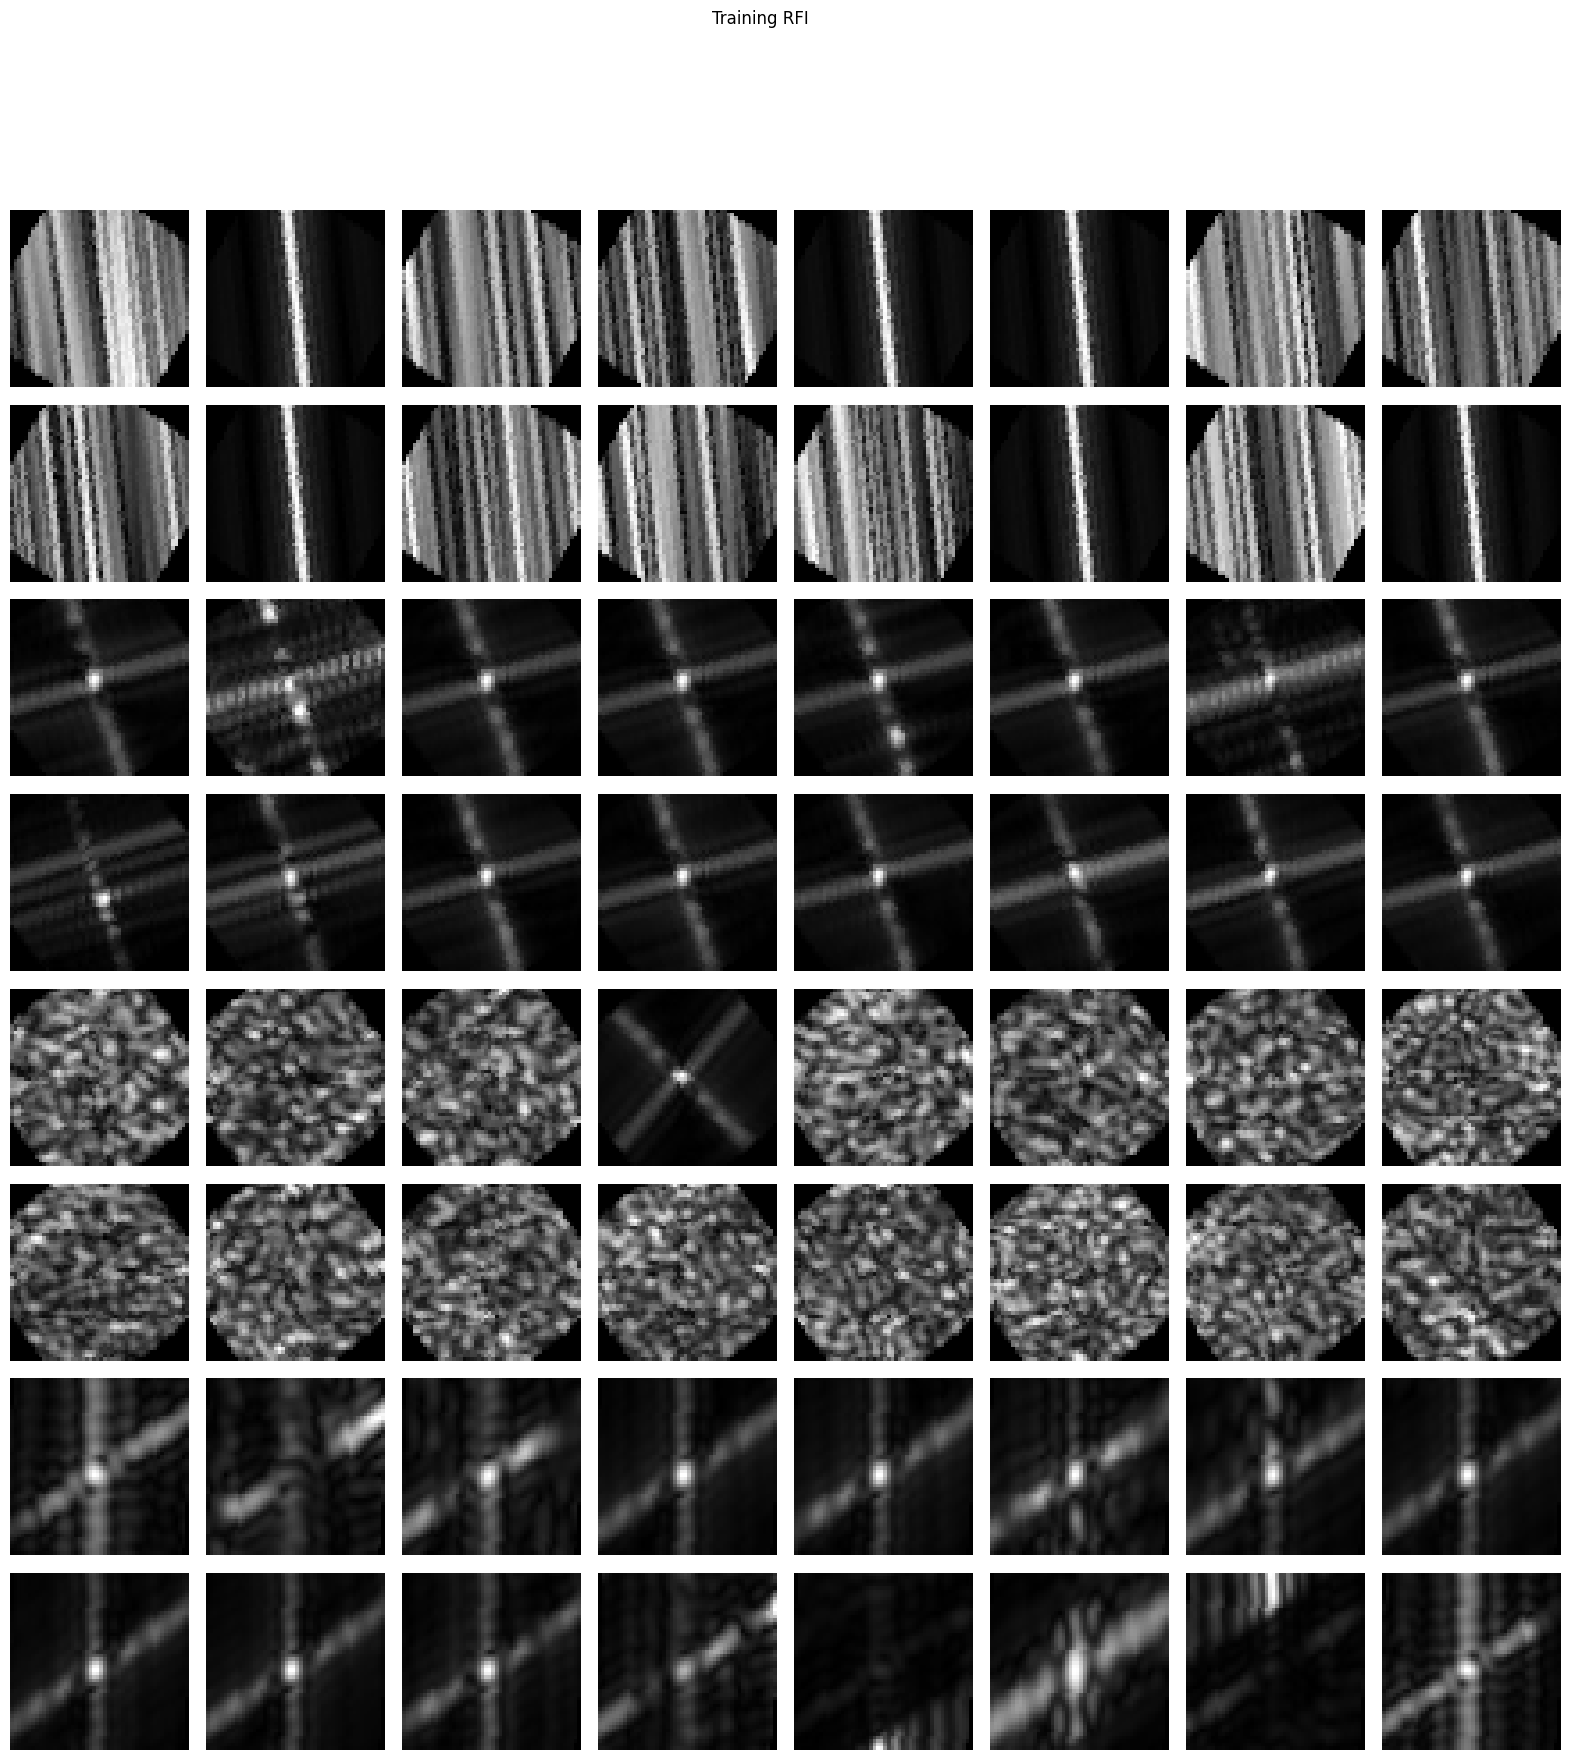

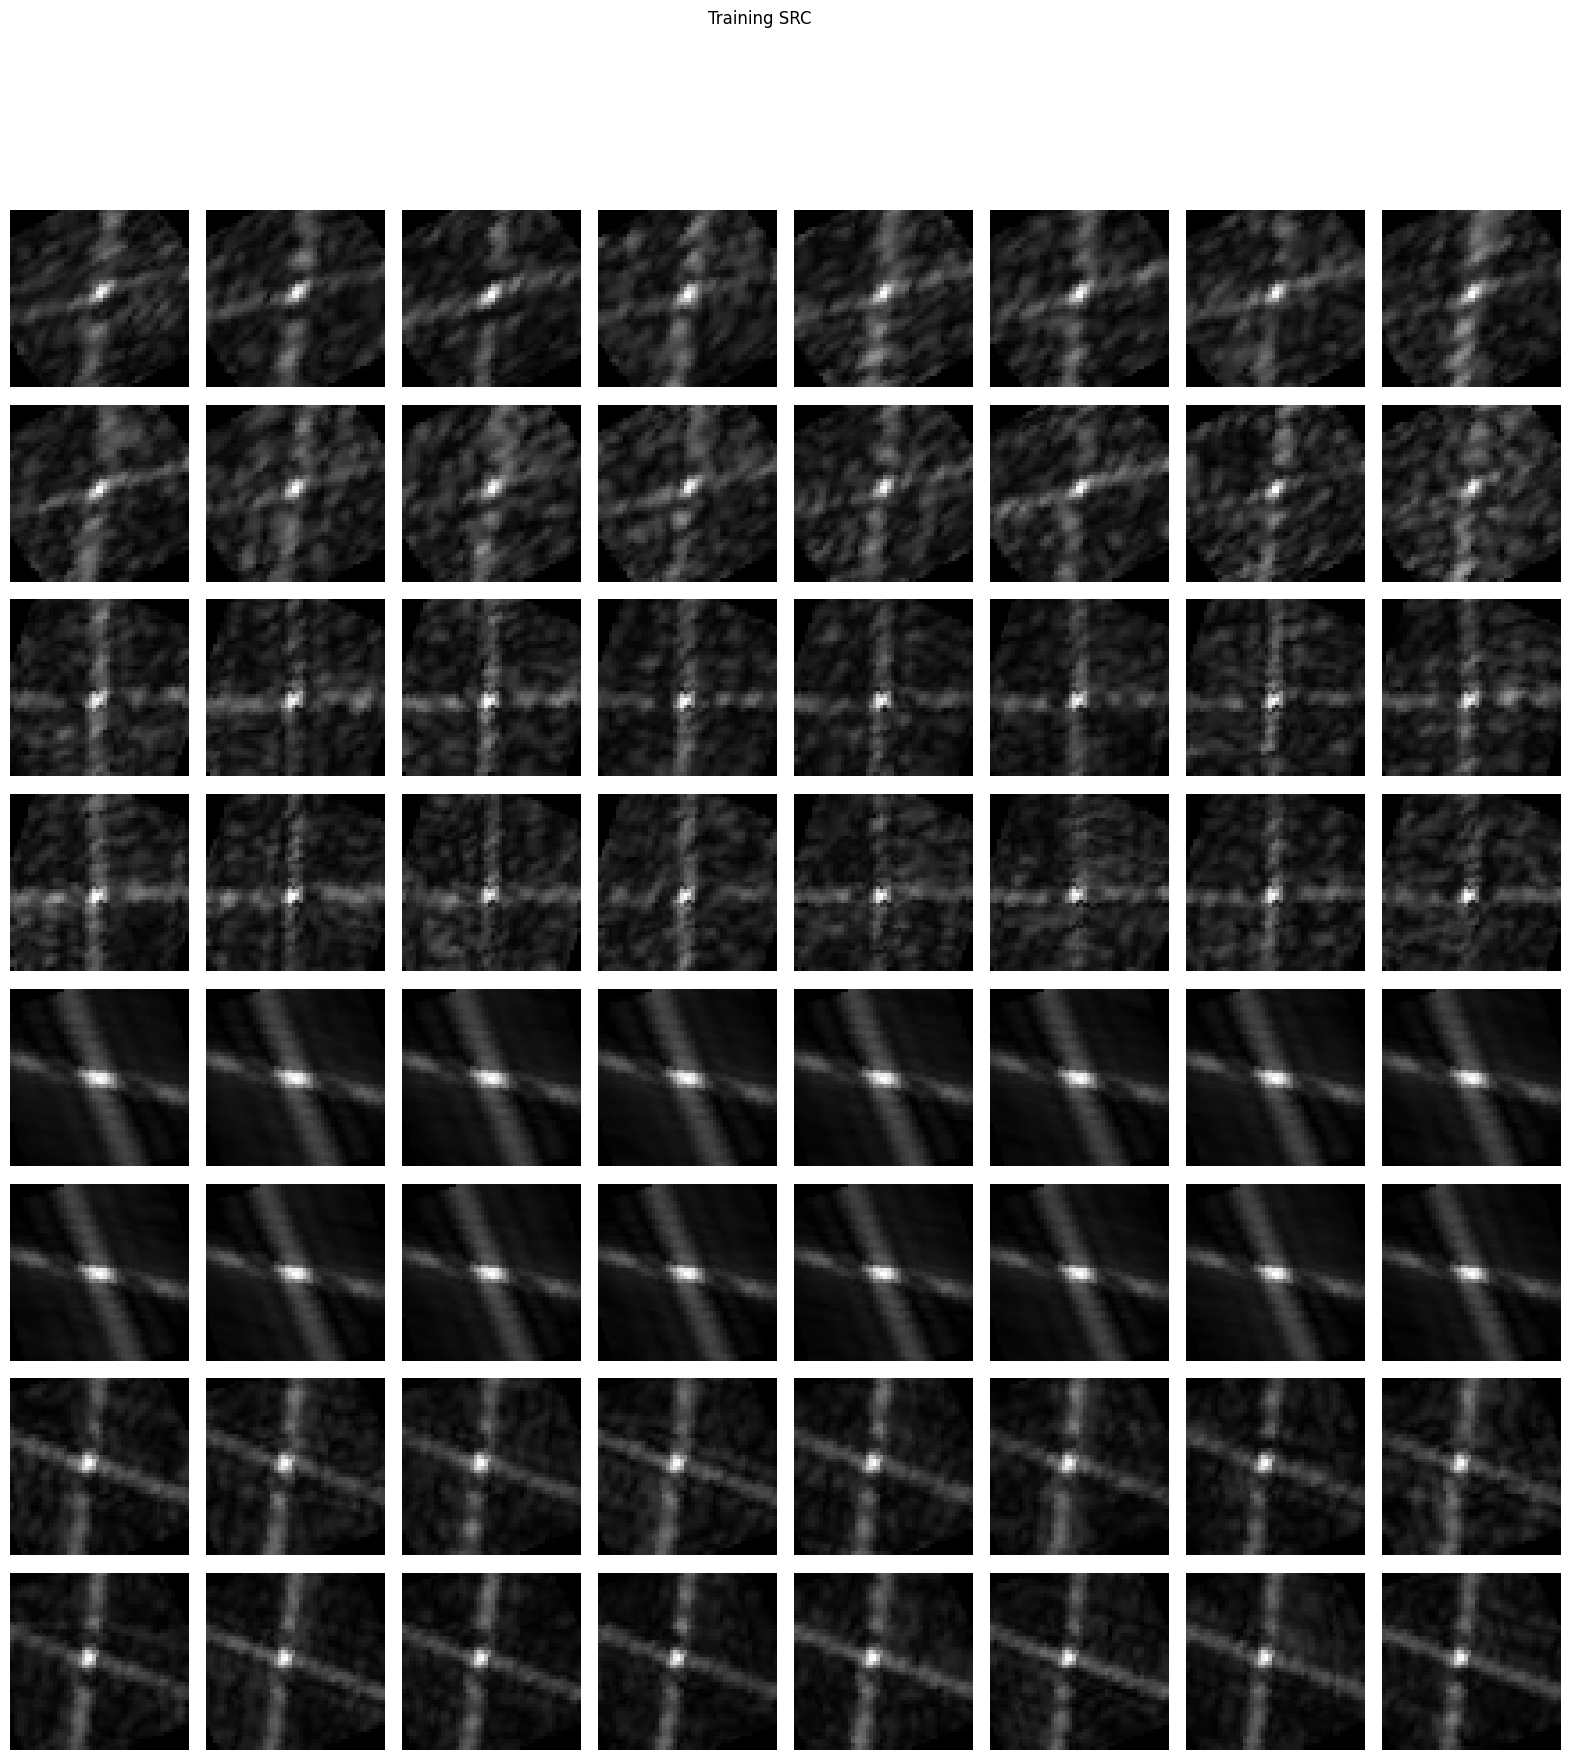

In [ ]:
# Display images (rfi and src)
#show_images(train_loader, num_images=4, title="Training RFI and SRC")
show_images(DataLoader(train_rfi_dataset, batch_size=4, shuffle=True), num_images=4, title="Training RFI")
show_images(DataLoader(train_src_dataset, batch_size=4, shuffle=True), num_images=4, title="Training SRC")


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # accepting 16 channels (subbands)
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 25 * 25, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []



# model,  loss function, optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0  # number of correct predictions
    total_train = 0  #  total number of predictions
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # predictions and  accuracy
        predicted = (outputs > 0.5).float()  # threshold set to 0.5
        correct_train += (predicted == labels.float()).sum().item()
        total_train += labels.size(0)

    accuracy_train = 100 * correct_train / total_train
    print(f"Training - Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy_train}%")
    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(accuracy_train)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()


            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels.float()).sum().item()
            total_val += labels.size(0)

    accuracy_val = 100 * correct_val / total_val
    print(f"Validation - Epoch {epoch+1}, Loss: {val_running_loss/len(val_loader)}, Accuracy: {accuracy_val}%")
    val_losses.append(val_running_loss/len(val_loader))
    val_accuracies.append(accuracy_val)

print('Finished Training')


Training - Epoch 1, Loss: 0.40848863243110595, Accuracy: 80.75%
Validation - Epoch 1, Loss: 0.22308156107153213, Accuracy: 91.0%
Training - Epoch 2, Loss: 0.2083044576029929, Accuracy: 92.45%
Validation - Epoch 2, Loss: 0.17959285793559893, Accuracy: 93.0%
Training - Epoch 3, Loss: 0.1688697228710803, Accuracy: 93.75%
Validation - Epoch 3, Loss: 0.14523986248033388, Accuracy: 92.0%
Training - Epoch 4, Loss: 0.10991880161658166, Accuracy: 96.55%
Validation - Epoch 4, Loss: 0.04682136486683573, Accuracy: 99.0%
Training - Epoch 5, Loss: 0.08101524820639974, Accuracy: 97.25%
Validation - Epoch 5, Loss: 0.04236046091786453, Accuracy: 98.5%
Training - Epoch 6, Loss: 0.059162227000804646, Accuracy: 98.25%
Validation - Epoch 6, Loss: 0.02560752404055425, Accuracy: 99.5%
Training - Epoch 7, Loss: 0.04859739952972011, Accuracy: 98.6%
Validation - Epoch 7, Loss: 0.06483412371017039, Accuracy: 97.5%
Training - Epoch 8, Loss: 0.04605051593500234, Accuracy: 98.75%
Validation - Epoch 8, Loss: 0.02948

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()


def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()


In [ ]:
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

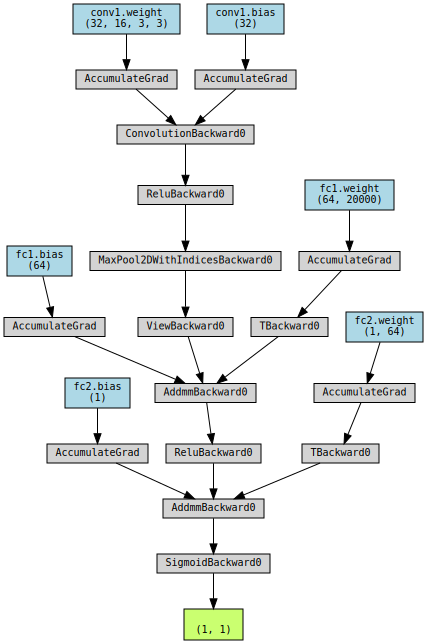

In [ ]:

model.eval()


dummy_input = torch.randn(1, 16, 50, 50)


output = model(dummy_input)


dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture")
dot


In [ ]:

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)


        self.fc1 = nn.Linear(6 * 6 * 256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x25x25
        x = self.pool(F.relu(self.conv2(x)))  # 128x12x12
        x = self.pool(F.relu(self.conv3(x)))  # 256x6x6


        x = x.view(-1, 6 * 6 * 256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x



In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []



# model,  loss function, optimizer
model = EnhancedCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    running_loss = 0.0
    correct_train = 0  # number of correct predictions
    total_train = 0  #  total number of predictions
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # predictions and  accuracy
        predicted = (outputs > 0.5).float()  # threshold set to 0.5
        correct_train += (predicted == labels.float()).sum().item()
        total_train += labels.size(0)

    accuracy_train = 100 * correct_train / total_train
    print(f"Training - Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy_train}%")
    train_losses.append(running_loss/len(train_loader))
    train_accuracies.append(accuracy_train)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_running_loss += loss.item()


            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels.float()).sum().item()
            total_val += labels.size(0)

    accuracy_val = 100 * correct_val / total_val
    print(f"Validation - Epoch {epoch+1}, Loss: {val_running_loss/len(val_loader)}, Accuracy: {accuracy_val}%")
    val_losses.append(val_running_loss/len(val_loader))
    val_accuracies.append(accuracy_val)

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training - Epoch 1, Loss: 0.2621846023797989, Accuracy: 87.55%
Validation - Epoch 1, Loss: 0.08345222540542875, Accuracy: 97.16666666666667%
Training - Epoch 2, Loss: 0.07106054702308029, Accuracy: 97.7%
Validation - Epoch 2, Loss: 0.07139525716928274, Accuracy: 98.16666666666667%
Training - Epoch 3, Loss: 0.061942927641794085, Accuracy: 98.25%
Validation - Epoch 3, Loss: 0.07278332028133598, Accuracy: 97.83333333333333%
Training - Epoch 4, Loss: 0.029910400083754212, Accuracy: 99.1%
Validation - Epoch 4, Loss: 0.05201995516606411, Accuracy: 99.16666666666667%
Training - Epoch 5, Loss: 0.037985356182820396, Accuracy: 98.8%
Validation - Epoch 5, Loss: 0.10725554412132815, Accuracy: 97.0%
Training - Epoch 6, Loss: 0.04412608061137144, Accuracy: 98.85%
Validation - Epoch 6, Loss: 0.05602017032766813, Accuracy: 99.0%
Training - Epoch 7, Loss: 0.025053374976982012, Accuracy: 99.35%
Validation - Epoch 7, Loss: 0.035881208229846764, Accuracy: 99.16666666666667%
Training - Epoch 8, Loss: 0.028

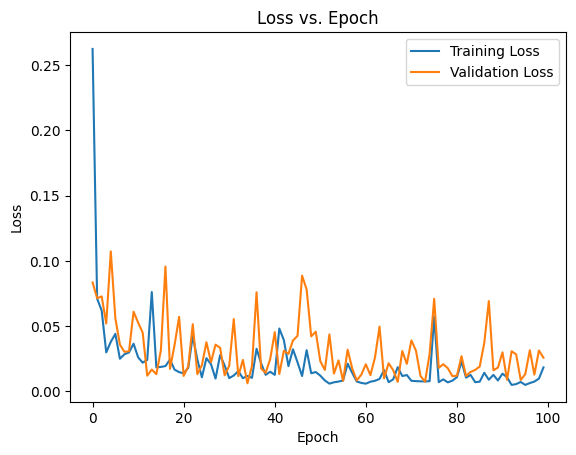

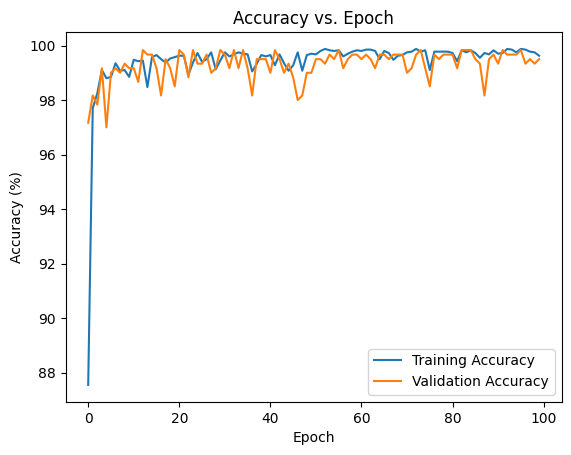

In [ ]:
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

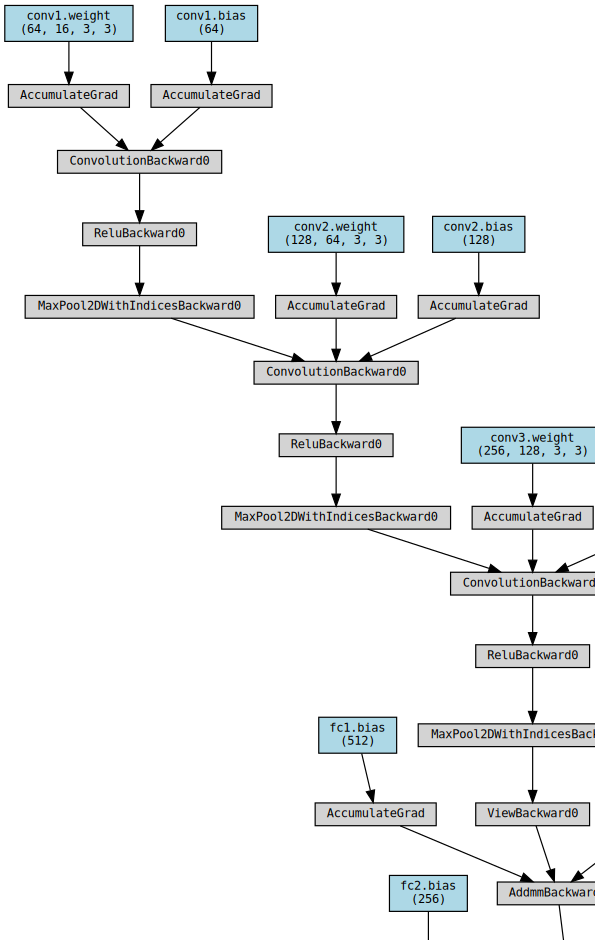

In [ ]:
model.eval()
dummy_input = torch.randn(1, 16, 50, 50)
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture")
dot

In [ ]:
#Saving
torch.save(model.state_dict(), 'model_weights.pth')

True label: 1 | Predicted: 0.0


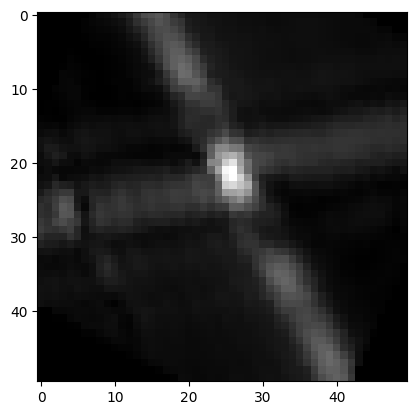

True label: 1 | Predicted: 0.0


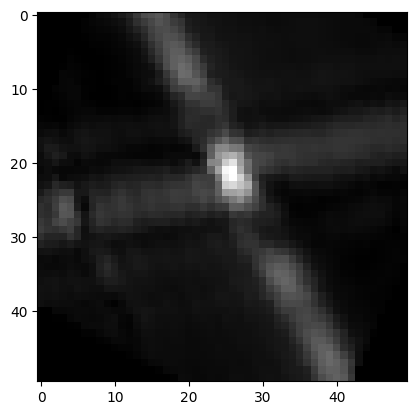

True label: 1 | Predicted: 0.0


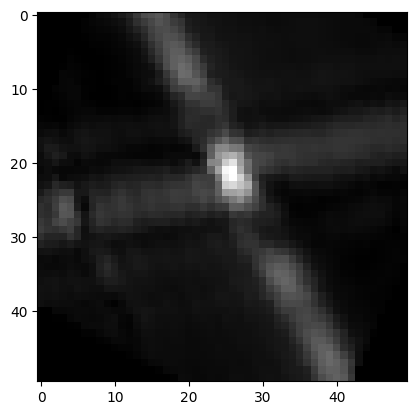

In [ ]:

def imshow(img, channel=0):
    npimg = img.numpy()
    plt.imshow(npimg[channel], cmap='gray')
    plt.show()



def evaluate_model(model, loader):
    wrong_images = []
    wrong_labels = []
    wrong_predictions = []
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()  # threshold

            # Wrong predictions
            wrong_indices = (predicted != labels.float())
            wrong_images.extend(inputs[wrong_indices])
            wrong_labels.extend(labels[wrong_indices].numpy())
            wrong_predictions.extend(predicted[wrong_indices].numpy())

    return wrong_images, wrong_labels, wrong_predictions


wrong_images, wrong_labels, wrong_predictions = evaluate_model(model, val_loader)


# wrongly classified images
for i in range(min(4, len(wrong_images))):
    print(f"True label: {wrong_labels[i]} | Predicted: {wrong_predictions[i]}")
    imshow(wrong_images[0], channel=0)


In [ ]:
#model = EnhancedCNN()
#model.load_state_dict(torch.load('model_weights.pth'))
#model.eval()